#Preparing the model for training, and installing darknet module

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Configuring paths for the model
path_cfg = "/content/gdrive/MyDrive/IIITB_intern/Darknet_model/yolo-obj.cfg"
path_data = "/content/gdrive/MyDrive/IIITB_intern/Darknet_model/obj.data"
path_pre_trained = "/content/gdrive/MyDrive/IIITB_intern/Darknet_model/pre-trained_weights/yolov4.conv.137"
path_saved_weights = "/content/gdrive/MyDrive/IIITB_intern/Darknet_model/Weights/yolo-obj_last.weights"
path_test_weights = "/content/gdrive/MyDrive/IIITB_intern/Darknet_model/Weights/yolo-obj_1000.weights"

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 13.99 MiB | 12.16 MiB/s, done.
Resolving deltas: 100% (10354/10354), done.


In [ ]:
#If using a gpu
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/OPENMP=0/OPENMP=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
#If using a cpu
%cd darknet 
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=0/' Makefile
!sed -i 's/CUDNN=0/CUDNN=0/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=0/' Makefile
!sed -i 's/OPENMP=0/OPENMP=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -fopenmp -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iterati

#Preparing data for training

In [ ]:
# Load image paths
import os
train_image_dir = '/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train'
filenames = []
paths = []

for filename in os.listdir(train_image_dir):
  image_path = os.path.join(train_image_dir, filename)
  paths.append(image_path)
  filenames.append(filename)
print(len(filenames))  

1130


In [ ]:
#Creating dataset files from csv file
import xml.etree.ElementTree as gfg
import pandas as pd
import numpy as np

In [ ]:
#finding images without any labels
df = pd.read_csv('/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train.csv')
for i in range(len(filenames)):
  filename = filenames[i]
  path = paths[i]
  df_img = df.loc[df['image_id'] == filenames[i]]
  if(df_img.empty):
    print(filename)

In [ ]:
#CSV to PascalVOC_Format
def GenerateXML(filename, path, df_img) :
	
  root = gfg.Element("annotation")
    
  e1 = gfg.SubElement(root,"folder")
  e1.text = 'train'
    
  e2 = gfg.SubElement(root,"filename")
  e2.text = filename
  
  e3 = gfg.SubElement(root,"path")
  e3.text = path
  
  e4 = gfg.SubElement(root,"source")
  s4_1 = gfg.SubElement(e4, "database")
  s4_1.text = "Unknown"
  
  e5 = gfg.SubElement(root,"size")
  s5_1 = gfg.SubElement(e5, "width")
  s5_1.text = str(df_img['width'][df_img.index[0]])
  s5_2 = gfg.SubElement(e5, "height")
  s5_2.text = str(df_img['height'][df_img.index[0]])
  s5_3 = gfg.SubElement(e5, "depth")
  s5_3.text = '3'

  e6 = gfg.SubElement(root,"segmented")
  e6.text = '0'

  for ind in df_img.index:
    bounds = df_img['bbox'][ind][1:-1].split(',')

    x = gfg.SubElement(root,"object")
      
    x1 = gfg.SubElement(x,"name")
    x1.text = "leaf"
      
    x2 = gfg.SubElement(x,"pose")
    x2.text = "unspecified"

    x3 = gfg.SubElement(x,"truncated")
    x3.text = "0"

    x4 = gfg.SubElement(x,"difficult")
    x4.text = "0"

    x5 = gfg.SubElement(x,"bndbox")
    x5_1 = gfg.SubElement(x5,"xmin")
    x5_1.text = bounds[0]
    x5_2 = gfg.SubElement(x5,"ymin")
    x5_2.text = bounds[1]
    x5_3 = gfg.SubElement(x5,"xmax")
    x5_3.text = str(int(bounds[0]) + int(bounds[2]))
    x5_4 = gfg.SubElement(x5,"ymax")
    x5_4.text = str(int(bounds[1]) + int(bounds[3]))

    tree = gfg.ElementTree(root)
    
    with open ("/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train/" + filename +".xml", "wb") as files :
      tree.write(files)

In [ ]:
#CSV to Yolo_darknet_txt_format

def GenerateYOLOtxt(filename, df_img):
  size = int(df_img['width'][df_img.index[0]])
  
  bbox = []
  for ind in df_img.index:
    bounds = df_img['bbox'][ind][1:-1].split(',')
    x = (int(bounds[0]) + int(bounds[2])/2)/size
    y = (int(bounds[1]) + int(bounds[3])/2)/size
    w = int(bounds[2])/size
    h = int(bounds[3])/size
    bbox.append([0, x, y, w, h])

  a_dataframe = pd.DataFrame(bbox)
  a_dataframe.to_csv('/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train/' + filename.split('.')[0]+ '.txt', sep='\t', index=False, header=False)


In [ ]:
#Generating Yolotxt files using GenerateYOLOtxt function

df = pd.read_csv('/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train.csv')
txt_count = 0

for i in range(len(filenames)):
  filename = filenames[i]
  path = paths[i]
  df_img = df.loc[df['image_id'] == filenames[i]]
  GenerateYOLOtxt(filename, df_img)
  txt_count = txt_count + 1
  print(txt_count)

In [ ]:
#Checking if txt files for training have been successfully created
import os

directory = "/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train"

files_in_directory = os.listdir(directory)
filtered_files = [file for file in files_in_directory if file.endswith(".txt")]
print(len(filtered_files))
#for file in filtered_files:
  #print(file)
  #path_to_file = os.path.join(directory, file)
  #os.remove(path_to_file)

1130


In [ ]:
#Creating train.txt for the yolo model
import glob
x = '.jpg'
imglist = glob.glob("/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train/*{}".format(x),recursive=False)
print(len(imglist))
with open("/content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/train.txt",'w',encoding='utf-8') as f:
  for img in imglist:
    img=img.replace("\\","/")
    f.write(img+'\n')

1130


#Loading the training model with pre-trained weights

In [ ]:
#Downloading pre-trained weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
#copying the pre-trained weights to your working folder
!cp yolov4.conv.137 /content/gdrive/MyDrive/IIITB_intern/Darknet_model/pre-trained_weights

In [ ]:
#Training 
#syntax - !./darknet detector train <path to obj.data> <path to custom config> <path to weight file> -dont_show -map

!./darknet detector train /content/gdrive/MyDrive/IIITB_intern/Darknet_model/obj.data /content/gdrive/MyDrive/IIITB_intern/Darknet_model/yolo-obj.cfg /content/gdrive/MyDrive/IIITB_intern/Darknet_model/pre-trained_weights/yolov4.conv.137 -dont_show -map


Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.672133), count: 8, class_loss = 1.997517, iou_loss = 0.338638, total_loss = 2.336155 
 total_bbox = 837959, rewritten_bbox = 0.106568 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.000000), count: 1, class_loss = 0.058064, iou_loss = 0.000000, total_loss = 0.058064 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.797013), count: 1, class_loss = 1.789482, iou_loss = 0.255466, total_loss = 2.044949 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.572645), count: 5, class_loss = 1.889265, iou_loss = 0.183986, total_loss = 2.073251 
 total_bbox = 837965, rewritten_bbox = 0.106568 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.498370), count: 18, class_loss = 9.144692, iou_loss = 21.396381, total_loss = 30.541075 

In [ ]:
#Resuming if colab disconnect
!./darknet detector train /content/gdrive/MyDrive/IIITB_intern/Darknet_model/obj.data /content/gdrive/MyDrive/IIITB_intern/Darknet_model/yolo-obj.cfg /content/gdrive/MyDrive/IIITB_intern/Darknet_model/Weights/yolo-obj_last.weights -dont_show

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.781765), count: 28, class_loss = 5.843793, iou_loss = 19.797539, total_loss = 25.641331 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.777185), count: 20, class_loss = 6.684439, iou_loss = 3.275713, total_loss = 9.960152 
 total_bbox = 1201043, rewritten_bbox = 0.098331 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.814351), count: 4, class_loss = 1.937050, iou_loss = 12.208565, total_loss = 14.145616 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.778847), count: 34, class_loss = 15.582433, iou_loss = 26.895142, total_loss = 42.477573 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.744744), count: 29, class_loss = 12.148841, iou_loss = 5.750461, total_loss = 17.899302 
 total_bbox = 1201110, rewritten_bbox =

In [ ]:
#Checking MAP 
!./darknet detector map /content/gdrive/MyDrive/IIITB_intern/Darknet_model/obj.data /content/gdrive/MyDrive/IIITB_intern/Darknet_model/yolo-obj.cfg /content/gdrive/MyDrive/IIITB_intern/Darknet_model/Weights/yolo-obj_1000.weights

In [ ]:
#Testing the model on an image
#Avoid using this and rather use the utility provided below this
!./darknet detector test /content/gdrive/MyDrive/IIITB_intern/Darknet_model/obj.data /content/gdrive/MyDrive/IIITB_intern/Darknet_model/yolo-obj.cfg /content/gdrive/MyDrive/IIITB_intern/Darknet_model/Weights/yolo-obj_last.weights /content/gdrive/MyDrive/IIITB_intern/Leaf_dataset/plant.jpg -thresh 0.3

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

#Testing the model on images

In [ ]:
def image_detection(image_path, network, class_names, class_colors, thresh):
    # Darknet doesn't accept numpy images.
    # Create one with image we reuse for each detect
    width = darknet.network_width(network)
    height = darknet.network_height(network)
    darknet_image = darknet.make_image(width, height, 3)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height),
                               interpolation=cv2.INTER_LINEAR)

    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
    darknet.free_image(darknet_image)
    image = darknet.draw_boxes(detections, image_resized, class_colors)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detections
    

In [ ]:
#Overwriting the github darknet.py file with edited darknet.py file
!cat /content/gdrive/MyDrive/IIITB_intern/Darknet_model/darknet.py > /content/darknet/darknet.py

In [ ]:
!python darknet.py

In [ ]:
import random
import darknet
import cv2
batch_size = 1 #number of images
random.seed(3)  # deterministic bbox colors
network, class_names, class_colors = darknet.load_network(
    path_cfg,
    path_data,
    path_test_weights,
    batch_size=batch_size
  )

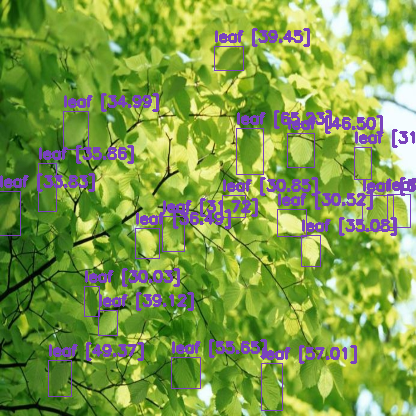

In [ ]:
img, det = image_detection("/content/TEST_001.jpg", network, class_names, class_colors, thresh = 0.3)

from google.colab.patches import cv2_imshow
cv2_imshow(img)